<a href="https://colab.research.google.com/github/harishjungshahi/Deep-Learning/blob/main/Early_Stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

In [19]:
df = pd.read_csv("sonar.all-data", header=None)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
48,0.0190,0.0038,0.0642,0.0452,0.0333,0.0690,0.0901,0.1454,0.0740,0.0349,0.1459,0.3473,0.3197,0.2823,0.0166,0.0572,0.2164,0.4563,0.3819,0.5627,0.6484,0.7235,0.8242,0.8766,1.0000,0.8582,0.6563,0.5087,0.4817,0.4530,0.4521,0.4532,0.5385,0.5308,0.5356,0.5271,0.4260,0.2436,0.1205,0.3845,0.4107,0.5067,0.4216,0.2479,0.1586,0.1124,0.0651,0.0789,0.0325,0.0070,0.0026,0.0093,0.0118,0.0112,0.0094,0.0140,0.0072,0.0022,0.0055,0.0122,R
112,0.0454,0.0472,0.0697,0.1021,0.1397,0.1493,0.1487,0.0771,0.1171,0.1675,0.2799,0.3323,0.4012,0.4296,0.5350,0.5411,0.6870,0.8045,0.9194,0.9169,1.0000,0.9972,0.9093,0.7918,0.6705,0.5324,0.3572,0.2484,0.3161,0.3775,0.3138,0.1713,0.2937,0.5234,0.5926,0.5437,0.4516,0.3379,0.3215,0.2178,0.1674,0.2634,0.2980,0.2037,0.1155,0.0919,0.0882,0.0228,0.0380,0.0142,0.0137,0.0120,0.0042,0.0238,0.0129,0.0084,0.0218,0.0321,0.0154,0.0053,M
98,0.1313,0.2339,0.3059,0.4264,0.4010,0.1791,0.1853,0.0055,0.1929,0.2231,0.2907,0.2259,0.3136,0.3302,0.3660,0.3956,0.4386,0.4670,0.5255,0.3735,0.2243,0.1973,0.4337,0.6532,0.5070,0.2796,0.4163,0.5950,0.5242,0.4178,0.3714,0.2375,0.0863,0.1437,0.2896,0.4577,0.3725,0.3372,0.3803,0.4181,0.3603,0.2711,0.1653,0.1951,0.2811,0.2246,0.1921,0.1500,0.0665,0.0193,0.0156,0.0362,0.0210,0.0154,0.0180,0.0013,0.0106,0.0127,0.0178,0.0231,M
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
145,0.0721,0.1574,0.1112,0.1085,0.0666,0.1800,0.1108,0.2794,0.1408,0.0795,0.2534,0.3920,0.3375,0.1610,0.1889,0.3308,0.2282,0.2177,0.1853,0.5167,0.5342,0.6298,0.8437,0.6756,0.5825,0.6141,0.8809,0.8375,0.3869,0.5051,0.5455,0.4241,0.1534,0.4950,0.6983,0.7109,0.5647,0.4870,0.5515,0.4433,0.5250,0.6075,0.5251,0.1359,0.4268,0.4442,0.2193,0.0900,0.1200,0.0628,0.0234,0.0309,0.0127,0.0082,0.0281,0.0117,0.0092,0.0147,0.0157,0.0129,M


In [20]:
df.shape

(208, 61)

In [21]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

In [6]:
df[60].value_counts()

,count
60,
M,111
R,97


In [22]:
df[60] = df[60].map({'R': 0, 'M': 1})
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0


In [23]:
X = df.drop(60, axis=1)
y = df[60]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [24]:
X_train.shape

(156, 60)

In [25]:
y_train.values

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0])

In [26]:
#convert the split array to pytorch tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [28]:
# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create Data Loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [40]:
# Train a Neural Network
class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(60, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,2) # Final Output layer without activation for raw logits
    )

  def forward(self, x):
    return self.network(x)

In [41]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

Epoch 1/20, Train Loss: 0.6915, Val Loss: 0.6809, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6769, Val Loss: 0.6717, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6713, Val Loss: 0.6669, Val Accuracy: 0.5192
Epoch 4/20, Train Loss: 0.6646, Val Loss: 0.6708, Val Accuracy: 0.5192
Epoch 5/20, Train Loss: 0.6516, Val Loss: 0.6509, Val Accuracy: 0.6346
Epoch 6/20, Train Loss: 0.6418, Val Loss: 0.6335, Val Accuracy: 0.7115
Epoch 7/20, Train Loss: 0.6262, Val Loss: 0.6182, Val Accuracy: 0.6923
Epoch 8/20, Train Loss: 0.6061, Val Loss: 0.5933, Val Accuracy: 0.7115
Epoch 9/20, Train Loss: 0.5901, Val Loss: 0.5870, Val Accuracy: 0.7115
Epoch 10/20, Train Loss: 0.5638, Val Loss: 0.5600, Val Accuracy: 0.8269
Epoch 11/20, Train Loss: 0.5420, Val Loss: 0.5323, Val Accuracy: 0.8077
Epoch 12/20, Train Loss: 0.5130, Val Loss: 0.5177, Val Accuracy: 0.7115
Epoch 13/20, Train Loss: 0.4857, Val Loss: 0.4979, Val Accuracy: 0.8077
Epoch 14/20, Train Loss: 0.4602, Val Loss: 0.4767, Val Accuracy: 0.7885
E

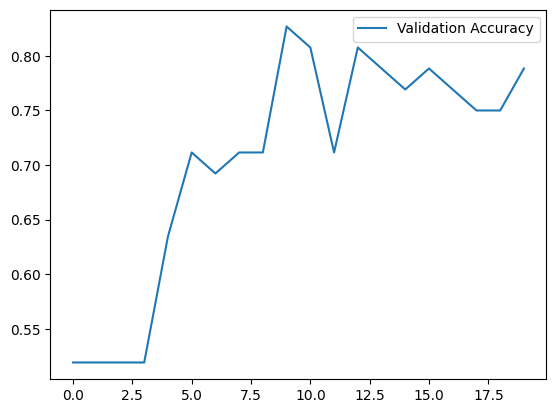

In [42]:
# Initialize and train the model without dropout
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, epochs=20
)

plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.show()

### Train a Neural Network With Early Stopping

In [44]:
# Training function
def train_model_early_stop(model, train_loader, val_loader, criterion, optimizer, epochs=20):

    patience = 3
    best_accuracy = 0
    counter = 0

    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")


        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early Stopping at Epoch {epoch+1}")
                break

    return train_losses, val_losses, val_accuracies

Epoch 1/20, Train Loss: 0.6884, Val Loss: 0.6861, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6807, Val Loss: 0.6779, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6713, Val Loss: 0.6692, Val Accuracy: 0.5385
Epoch 4/20, Train Loss: 0.6631, Val Loss: 0.6618, Val Accuracy: 0.6538
Epoch 5/20, Train Loss: 0.6506, Val Loss: 0.6449, Val Accuracy: 0.6538
Epoch 6/20, Train Loss: 0.6331, Val Loss: 0.6280, Val Accuracy: 0.6731
Epoch 7/20, Train Loss: 0.6145, Val Loss: 0.6024, Val Accuracy: 0.7308
Epoch 8/20, Train Loss: 0.5894, Val Loss: 0.5760, Val Accuracy: 0.7115
Epoch 9/20, Train Loss: 0.5693, Val Loss: 0.5652, Val Accuracy: 0.7115
Epoch 10/20, Train Loss: 0.5372, Val Loss: 0.5396, Val Accuracy: 0.8462
Epoch 11/20, Train Loss: 0.5203, Val Loss: 0.5288, Val Accuracy: 0.7115
Epoch 12/20, Train Loss: 0.4896, Val Loss: 0.4846, Val Accuracy: 0.7692
Epoch 13/20, Train Loss: 0.4635, Val Loss: 0.4920, Val Accuracy: 0.7500
Early Stopping at Epoch 13


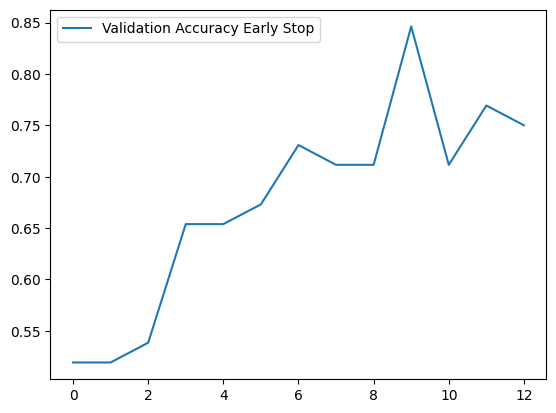

In [45]:
# Initialize and train the model without dropout
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, val_accuracies = train_model_early_stop(
    model, train_loader, test_loader, criterion, optimizer, epochs=20
)

plt.plot(val_accuracies, label="Validation Accuracy Early Stop")
plt.legend()
plt.show()

In [46]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [47]:
# Validation phase
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
val_accuracy = accuracy_score(y_true, y_pred)
val_accuracy

0.8461538461538461